In [42]:
import json
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dataloader import *

data = []

# Load David's preliminary data
# with open('../preliminary/david-first-eighty.json') as f:
#     data += json.load(f)

# Load tutorial feedback
# for filename in os.listdir('../tutorial/'):
#     with open('../tutorial/' + filename) as f:
#         individual_annotation = json.load(f)
#         for entry in individual_annotation:
#             entry['user'] = filename.split('.')[0]
#         data += individual_annotation

# Load batch 1 data
batch_num = 1
for filename in [x for x in os.listdir('../annotated/') if x.startswith('batch_' + str(batch_num))]:
    with open('../annotated/' + filename) as f:
        individual_annotation = json.load(f)
        
        for entry in individual_annotation:
            entry['user'] = filename.split('.')[0].split('_')[-1]
        data += individual_annotation

In [43]:
# Print spans with comments
for entry in data:
    if 'comment' in entry.keys():
        print(f"{entry['user'].upper()} - HIT {str(entry['id']+1)}: {entry['comment']}")

ANTON - HIT 19: in this case later baptised is a perfect deletion, but in other cases it might not be. 

AYUSH - HIT 10: There is no change from the original sentence to simplified sentence
AYUSH - HIT 15: Seems to think the original sentence is talking about a game?
AYUSH - HIT 25: It's the same sentence just duplicated twice
KELLY - HIT 6: This original sentence doesn't really make geographic sense. Tajikistan, Turmenistan, and Uzbekistan are north of both Afghanistan and Pakistan, east of Iran, and west of China.
KELLY - HIT 10: No change?
KELLY - HIT 15: This hit keeps breaking the interface for me, so I'm not sure what the data looks like. Once I get to this hit, the interface will not allow me to navegate off.
KELLY - HIT 16: I researched it and it looks like the (e) is indicating an alternate spelling on her name, but I'm not sure.
KELLY - HIT 25: Same sentence, no annotations needed.

KELLY - HIT 40: Annotating the splits is causing the interface to glitch and annotations stop 

In [44]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [45]:
data = consolidate_edits(data)          # Adds 'edits' field
data = consolidate_annotations(data)    # Adds 'processed_annotations' field

Couldn't process grammar for annotation: ['positive', '', '', '']
Couldn't process grammar for annotation: ['positive', 'minor', '', '']
Couldn't process grammar for annotation: ['positive', 'a lot', '', '']
Couldn't process grammar for annotation: ['positive', 'somewhat', '', '']


In [46]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

{'edit_type': 'deletion', 'id': 0, 'information_impact': <Information.LESS: 1>, 'type': <Quality.ERROR: 3>, 'grammar_error': False, 'error_type': <Error.COREFERENCE: 1>, 'rating': 2}
{'edit_type': 'deletion', 'id': 0, 'information_impact': <Information.LESS: 1>, 'type': <Quality.ERROR: 3>, 'grammar_error': False, 'error_type': <Error.COREFERENCE: 1>, 'rating': 1}
{'edit_type': 'deletion', 'id': 1, 'information_impact': <Information.LESS: 1>, 'type': <Quality.ERROR: 3>, 'grammar_error': False, 'error_type': <Error.COREFERENCE: 1>, 'rating': 1}
{'edit_type': 'deletion', 'id': 1, 'information_impact': <Information.LESS: 1>, 'type': <Quality.ERROR: 3>, 'grammar_error': False, 'error_type': <Error.COREFERENCE: 1>, 'rating': 1}
{'edit_type': 'deletion', 'id': 1, 'information_impact': <Information.LESS: 1>, 'type': <Quality.ERROR: 3>, 'grammar_error': False, 'error_type': <Error.COREFERENCE: 1>, 'rating': 0}
{'edit_type': 'deletion', 'id': 1, 'information_impact': <Information.LESS: 1>, 'type

In [47]:
# Example: Annotations for sentence 0
data[0]['processed_annotations']

[{'edit_type': 'deletion',
  'id': 0,
  'information_impact': <Information.LESS: 1>,
  'type': <Quality.ERROR: 3>,
  'grammar_error': False,
  'error_type': <Error.COREFERENCE: 1>,
  'rating': 2}]

In [48]:
# Example: Edits for sentence 0
data[0]['edits']

[{'type': 'deletion',
  'id': 0,
  'original_span': (11, 20),
  'simplified_span': None,
  'annotation': ['good', 'yes', 'no']}]

In [49]:
# Create sums of different dimensions
sum_edit_types = {system: sum_edits(data, system=system) for system in systems}
sum_info_change_types = {system: sum_info_change(data, system=system) for system in systems}
sum_errors_types = {system: sum_errors(data, system=system) for system in systems}
# display(sum_edit_types)

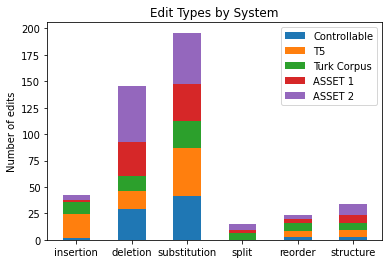

In [50]:
# Example: plot edit types by system
# We need a list because order matters here...
edit_type_labels = ['insertion', 'deletion', 'substitution', 'split', 'reorder', 'structure']
system_labels = [x for x in [
    'systems/Hybrid.lower',
    'systems/Dress-Ls.lower',
    'systems/lstm_w_split.txt',
    'systems/transformer_w_split.txt',
    'systems/con_simplification.txt',
    'systems/T5.txt',
    'new_systems/turk_corpus_random.txt',
    'new_systems/simple_wiki.txt',
    'systems/asset.test.simp',
    'new_systems/asset.test.simp.second'
] if x in systems]
width = 0.5

fig, ax = plt.subplots(figsize=(6, 4))
bottom = [0 for x in range(len(edit_types))]

for system in system_labels:
       val = [sum_edit_types[system][label] for label in edit_type_labels]
       ax.bar(edit_type_labels, val, width, bottom=bottom, label=system_name_mapping[system])
       bottom = [bottom[i] + val[i] for i in range(len(val))]
ax.set_ylabel('Number of edits')
ax.set_title('Edit Types by System')
ax.legend()

# plt.rcParams['figure.dpi'] = 300

plt.show()

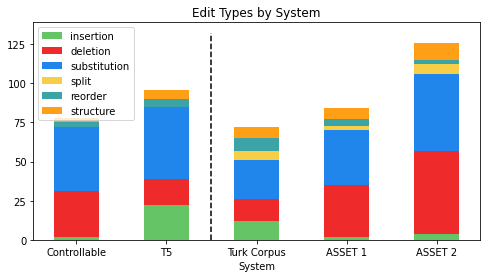

In [51]:
# Same as the above plot but but flip the dimensions
fig, ax = plt.subplots(figsize=(8, 4))

bottom = [0 for x in range(len(system_labels))]
for edit_type in edit_type_labels:
        val = [sum_edit_types[label][edit_type] for label in system_labels]
        displayed_x_labels = [system_name_mapping[label] for label in system_labels]
        ax.bar(displayed_x_labels, val, width, bottom=bottom, label=edit_type, color=color_mapping[edit_type])
        bottom = [bottom[i] + val[i] for i in range(len(val))]
ax.set_xlabel('System')
ax.set_title('Edit Types by System')
ax.set_yticks([i*round(max(bottom)/5) for i in range(6)])
ax.plot([1.5, 1.5], [0, ax.get_ylim()[-1]], ls='--', c='k')
ax.legend()
plt.show()

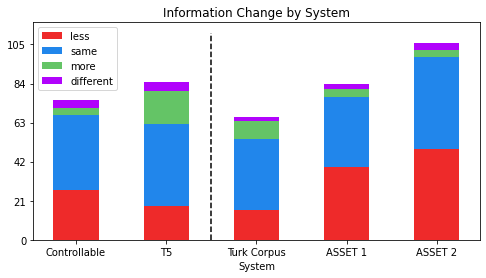

In [52]:
# Same as the plot above but instead lexical, syntactic, and content simplification
fig, ax = plt.subplots(figsize=(8, 4))

information_change_labels = [inn for inn in information_mapping.values()]

bottom = [0 for x in range(len(system_labels))]
for in_change in information_change_labels:
    val = [sum_info_change_types[label][in_change] for label in system_labels]
    displayed_x_labels = [system_name_mapping[label] for label in system_labels]
    ax.bar(displayed_x_labels, val, width, bottom=bottom, label={information_mapping[k]: k for k in information_mapping}[in_change], color=information_change_color_mapping[in_change])
    bottom = [bottom[i] + val[i] for i in range(len(val))]
ax.set_xlabel('System')
ax.set_title('Information Change by System')
ax.set_yticks([i*round(max(bottom)/5) for i in range(6)])
ax.plot([1.5, 1.5], [0, ax.get_ylim()[-1]], ls='--', c='k')
ax.legend()
plt.show()

In [53]:
# Idea: Of the paraphrases, what are the ratings?
# could do like a set of bar graphs centered around 0, where 0 is no impact.

In [54]:
# T5 inserts way more than human annotators, how many are errors?

In [55]:
# Create a tree of edit types, following the decision tree
root = Node(count_data(data), 'edits', -1)

counter = 0
for edit_type in edit_types:
    root.add_child(Node(count_data(data, edit_type=edit_type), edit_type, counter))
    counter += 1

for node in root.get_children():
    for info_change in information_mapping.values():
        node.add_child(Node(count_data(data, edit_type=node.label, information_impact=info_change), info_change, counter))
        counter += 1
    for child in node.get_children():
        for quality_type in Quality:
            child.add_child(Node(count_data(data, edit_type=node.label, information_impact=child.label, quality_type=quality_type), quality_type, counter))
            counter += 1

# Convert the tree to a list of nodes & links
stack = [child for child in root.get_children()]
nodes, links = [], []
while len(stack) > 0:
    node = stack.pop()

    # Map color if it has a mapping
    color = 'black'
    if node.label in color_mapping.keys():
        color = color_mapping[node.label]
    if node.label in information_change_color_mapping.keys():
        color = information_change_color_mapping[node.label]

    # Map label if it has a mapping
    label = node.label
    in_mapping_back = {information_mapping[k]: k for k in information_mapping}
    if node.label in in_mapping_back.keys():
        label = in_mapping_back[node.label]
    impact_mapping_back = {impact_mapping[k]: k for k in impact_mapping}
    if node.label in impact_mapping_back.keys():
        label = impact_mapping_back[node.label]

    nodes.append({'id': node.id, 'label': label, 'color': color})

    # Get links to children
    for child in node.get_children():
        if child.amount > 0:
            links.append({'source': node.id, 'target': child.id, 'value': child.amount})
        stack.append(child)

# Sort nodes by id
nodes = sorted(nodes, key=lambda x: x['id'])

# Convert dict tree values to lists
labels, colors = [str(x['label']) for x in nodes], [x['color'] for x in nodes]
sources, targets, values = [x['source'] for x in links], [x['target'] for x in links], [x['value'] for x in links]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = colors
    ),
    link = dict(
      source = sources, # index of source node
      target = targets, # index of end node
      value = values,   # amount in link
      # label = data['link']['label'],   # label of link (not necessary)
      # color = data['link']['color']
    ),
    valueformat = "d",
    valuesuffix = " edits"
  )
])

fig.update_layout(title_text="Edit Type Distribution", font_size=11, width=500, height=500)
fig.show()

# This is a start, but perhaps combine the same categories? Also have this be a full tree (i.e. show error types?)

# I actually think this chart would be great if the final row had colors and specific labels (ex. Elaboration, Trivial Insertions, Paraphrase, etc.)

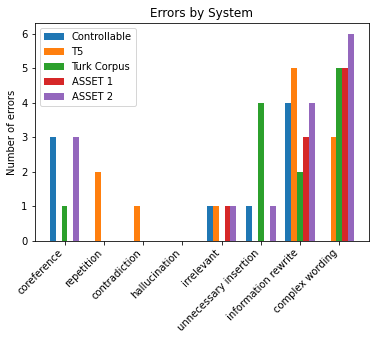

In [56]:
import numpy as np
plotted_errors = [
    Error.COREFERENCE, 
    Error.REPETITION,  
    Error.CONTRADICTION,  
    Error.HALLUCINATION,  
    Error.IRRELEVANT, 
    Error.UNNECESSARY_INSERTION, 
    Error.INFORMATION_REWRITE,
    Error.COMPLEX_WORDING
]

error_labels = [str(x).split('.')[1].lower().replace('_',' ') for x in plotted_errors]

fig, ax = plt.subplots(figsize=(6, 4))
bottom = [0 for x in range(len(error_labels))]

width = 0.15

count = 0 
for system in system_labels:
       val = [sum_errors_types[system][label] for label in plotted_errors]
       x = np.arange(len(error_labels))
       ax.bar(x-(2*width)+count*width, val, width, label=system_name_mapping[system])
       bottom = [bottom[i] + val[i] for i in range(len(val))]
       count += 1
ax.set_ylabel('Number of errors')
ax.set_title('Errors by System')
ax.legend()

# plt.rcParams['figure.dpi'] = 300

plt.xticks(x, error_labels, rotation=45, ha="right")
plt.show()